# Peeking into the data


**Table of contents**<a id='toc0_'></a>    
- [Definitions](#toc1_)    
- [Electrode labeling](#toc2_)    
- [Banana montage](#toc3_)    
- [How many different combinations of votes?](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
# import librosa

fs = 200  # Sample rate is 200 Hz. 

In [3]:
# base_dir = '../../kaggle_data/hms'
base_dir = '../../data/hms'
# base_dir = '/kaggle/input/hms-harmful-brain-activity-classification'

train_files = os.listdir(f'{base_dir}/train_eegs')
os.listdir(base_dir)

['train_eegs',
 'sample_submission.csv',
 'train_spectrograms',
 'test_spectrograms',
 'train.csv',
 'example_figures',
 'test.csv',
 'test_eegs']

In [4]:
df_traincsv = pd.read_csv(f'{base_dir}/train.csv')
# train.sample(10)
print(df_traincsv.shape)
df_traincsv.head()

(106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [5]:
classes = df_traincsv.expert_consensus.unique()
classes

array(['Seizure', 'GPD', 'LRDA', 'Other', 'GRDA', 'LPD'], dtype=object)

## <a id='toc1_'></a>[Definitions](#toc0_)

In [17]:
def plot_eeg(ax, eeg, title, sep):
    srate = 200 # Sample rate.
    nx = eeg.shape[0]
    totaltime = nx/srate
    X, Y = np.linspace(0, totaltime, nx), np.zeros(nx)
    yticklabels = eeg.columns[::-1]  # Reversed.

    for i, label in enumerate(yticklabels):
        Y = eeg[label]
        ax.plot(X, Y + (i * sep), linewidth=0.5, color='black')

    ax.set_title(title)
    ax.set(ylim=(-0.5*sep, (len(yticklabels)-0.5)*sep),
           yticks=np.arange(len(yticklabels))*sep,
           yticklabels=yticklabels)
    ax.set_xlabel('time [s]')

def banana(eeg_absolute):
    '''Returns pandas dataframe with a banana montage.
    '''
    eeg = pd.DataFrame(data={
        'Fp1-F7' : eeg_absolute.Fp1 - eeg_absolute.F7,
        'Fp7-T3' : eeg_absolute.F7 - eeg_absolute.T3,
        'T3-T5' : eeg_absolute.T3 - eeg_absolute.T5,
        'T5-O1' : eeg_absolute.T5 - eeg_absolute.O1,

        'Fp2-F8' : eeg_absolute.Fp2 - eeg_absolute.F8,
        'F8-T4' : eeg_absolute.F8 - eeg_absolute.T4,
        'T4-T6' : eeg_absolute.T4 - eeg_absolute.T6,
        'T6-O2' : eeg_absolute.T6 - eeg_absolute.O2,

        'Fp1-F3' : eeg_absolute.Fp1 - eeg_absolute.F3,
        'F3-C3' : eeg_absolute.F3 - eeg_absolute.C3,
        'C3-P3' : eeg_absolute.C3 - eeg_absolute.P3,
        'P3-O1' : eeg_absolute.P3 - eeg_absolute.O1,

        'Fp2-F4' : eeg_absolute.Fp2 - eeg_absolute.F4,
        'F4-C4' : eeg_absolute.F4 - eeg_absolute.C4,
        'C4-P4' : eeg_absolute.C4 - eeg_absolute.P4,
        'P4-O2' : eeg_absolute.P4 - eeg_absolute.O2,

        'Fz-Cz' : eeg_absolute.Fz - eeg_absolute.Cz,
        'Cz-Pz' : eeg_absolute.Cz - eeg_absolute.Pz,

        'EKG' : eeg_absolute.EKG
        })
    return eeg

https://www.learningeeg.com/

1. High pass filter: 1 Hz
1. low pass filter: 70 Hz
1. notch filter: 60 Hz or 50 Hz
1. PDR: posterior dominant rhythm, a key finding of the normal bakground. Alpha is 8-13 Hz.
1. Classic epileptiform spike is biphasic.
1. an extreme example of monomorphic waves may be found in seizures, in which repetitive spike and wave activity often looks very similar in portions of the seizure.
1. Continuity, symmetry, and anterior posterior gradient, in which faster, lower amplitude frequencies are present towards the front of the brain while slower, higher amplitude frequencies are found in the back of the brain.
1. PDR (8.5-12 Hz) emerges right after the patient closes their eyes (the eye closure is seen as the large positive wave right before the blue box). If there is a more than 50% difference in amplitude or a more than 1 Hz difference in frequency between sides, this is abnormal. Up to 5% of normal people have no PDR at all.
1. Variability and reactivity.
1. Eye blinks should really only be seen in the frontal leads, without any field into the posterior regions.
1. ECG artifact is marked by waveforms that are time locked to the QRS complex on the ECG tracing. They tend to be present more so or entirely on the left side,
1. other artifacts
1. wickets are seen in the temporal chains. Don't confuse wickets for epileptiform discharges (even when some wickets may be larger in amplitude than others) as wickets have no aftergoing slow wave, do not disturb the background, and are nonevolving even though they may come in runs.



## <a id='toc2_'></a>[Electrode labeling](#toc0_)

<div>
    <image src="../images/21_electrodes_of_International_10-20_system_for_EEG.svg" width="400">
</div>

Each electrode placement site has a letter to identify the lobe, or area of the brain it is reading from: pre-frontal (Fp), frontal (F), temporal (T), parietal (P), occipital (O), and central (C). Note that there is no "central lobe"; due to their placement, and depending on the individual, the "C" electrodes can exhibit/represent EEG activity more typical of frontal, temporal, and some parietal-occipital activity.

Even-numbered electrodes (2,4,6,8) refer to electrode placement on the right side of the head, whereas odd numbers (1,3,5,7) refer to those on the left.


In [6]:
eeg_id = 493696785
eeg_sub_id = 3  # seizure
# eeg_id = 1029863597
# eeg_sub_id = 15  # seizure
# eeg_id = 3988090520
# eeg_sub_id = 1

# Random eeg when working with a data sample.
# (not all eeg_id files are present)
#
# filename = random.choice(train_files)
# eeg_id = int(filename.split('.')[0])


# Random eeg when working with the complete dataset.
# eeg_id = random.choice(df_traincsv.eeg_id)

# filename = str(eeg_id) + ".parquet"
# path_eeg = base_dir / "train_eegs" / filename
eeg = pd.read_parquet(f'{base_dir}/train_eegs/{eeg_id}.parquet')
# eeg = pd.read_parquet(path_eeg)

print(eeg.shape)
eeg.head()

(32400, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0
1,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0
2,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0
3,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0
4,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0


In [7]:
# rec = df_traincsv.loc[df_traincsv.eeg_id == eeg_id].sample(1).iloc[0] # Random sub_id.
rec = df_traincsv.loc[(df_traincsv.eeg_id == eeg_id) & (df_traincsv.eeg_sub_id == eeg_sub_id)].iloc[0]
rec

eeg_id                               493696785
eeg_sub_id                                   3
eeg_label_offset_seconds                  46.0
spectrogram_id                       458831369
spectrogram_sub_id                           3
spectrogram_label_offset_seconds          46.0
label_id                            1547083774
patient_id                               42180
expert_consensus                       Seizure
seizure_vote                                 3
lpd_vote                                     0
gpd_vote                                     0
lrda_vote                                    0
grda_vote                                    0
other_vote                                   0
Name: 23571, dtype: object

In [8]:
# 50 second and center 10 second eeg sub samples 
offset = int(rec.eeg_label_offset_seconds)
start = offset * fs
end = (offset + 50) * fs
eeg_sub_50 = eeg[start:end]
start = (offset + 20) * fs
end = (offset + 30) * fs
eeg_sub_10 = eeg[start:end]

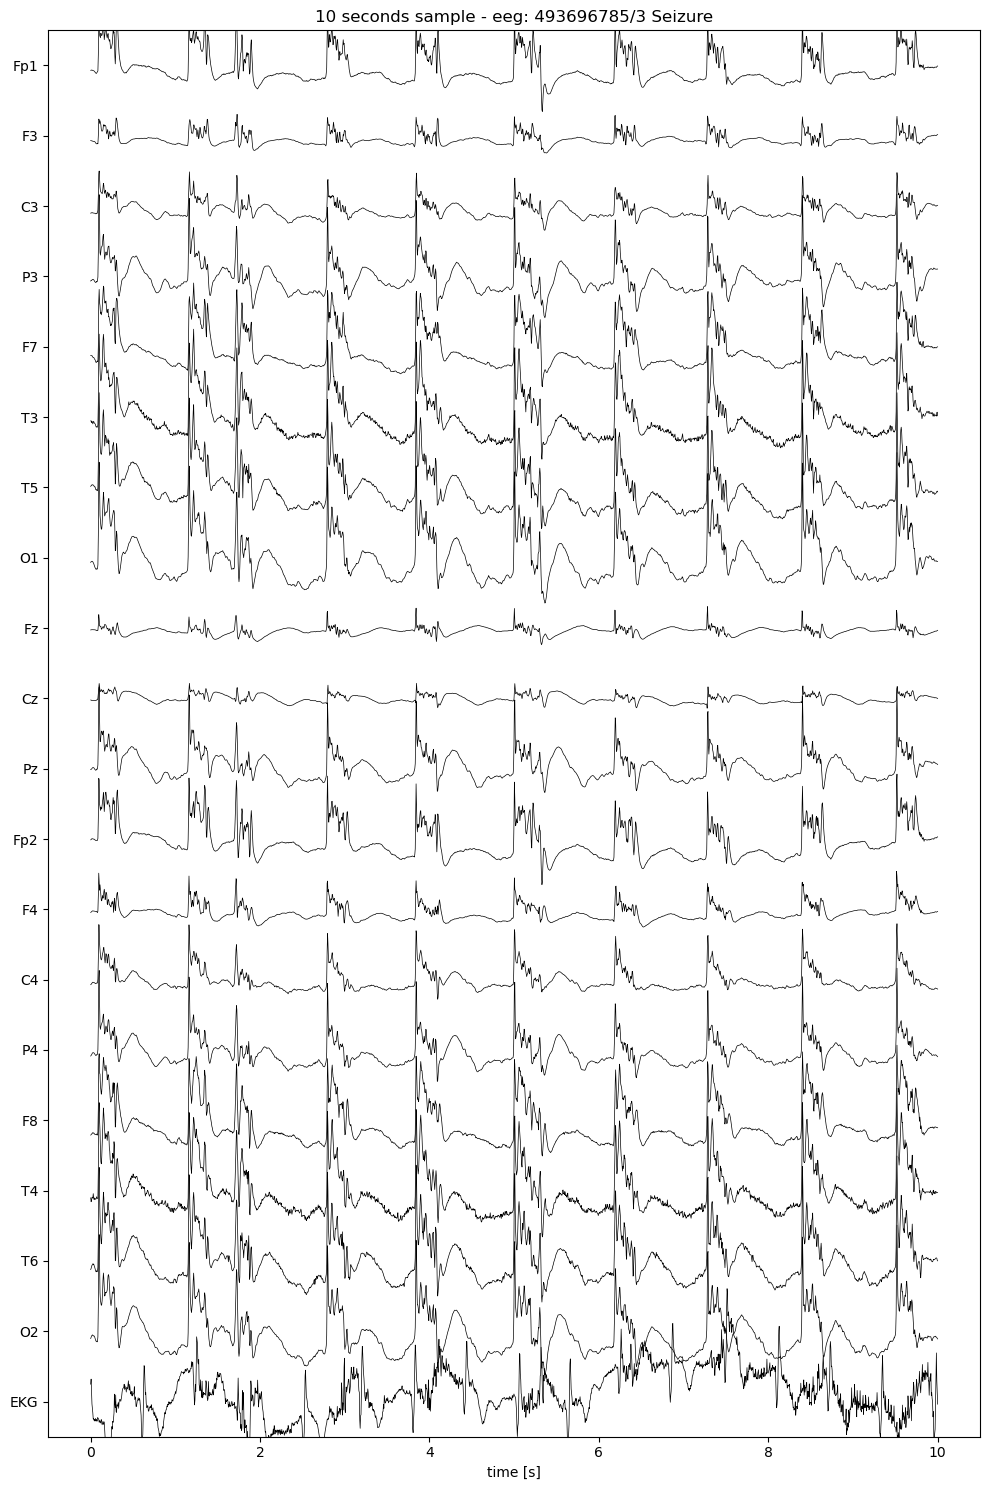

In [9]:


fig, ax = plt.subplots(1, 1, figsize=(10, 15))

plot_eeg(ax, eeg_sub_10, title='10 seconds sample - eeg: ' + str(rec.eeg_id)
          + '/' + str(rec.eeg_sub_id) + ' ' + rec.expert_consensus, sep = 500)

plt.tight_layout()
plt.show()

## <a id='toc3_'></a>[Banana montage](#toc0_)

<div>
    <image src="../images/banana_montage.png" width="800">
    <!-- <image src="../images/banana_montage.png"> -->
</div>


In [6]:
eeg_id = 493696785
eeg_sub_id = 3  # seizure
eeg_absolute = pd.read_parquet(f'{base_dir}/train_eegs/{eeg_id}.parquet')


In [18]:
eeg = banana(eeg_absolute)
eeg

,Fp1-F7,Fp7-T3,T3-T5,T5-O1,Fp2-F8,F8-T4,T4-T6,T6-O2,Fp1-F3,F3-C3,C3-P3,P3-O1,Fp2-F4,F4-C4,C4-P4,P4-O2,Fz-Cz,Cz-Pz,EKG
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32395,23.540009,-37.800003,128.570007,-336.190002,23.190002,11.479996,-85.029999,-13.910000,-136.259995,-4.300003,-38.590000,-42.730000,18.080002,-64.620003,-10.929999,-6.800000,-14.379999,4.840000,112.190002
32396,27.210007,-33.929993,123.319992,-334.970001,25.570000,10.750000,-79.169998,-15.070001,-130.399994,-4.070000,-33.959999,-49.939999,25.120003,-62.260002,-7.750000,-13.030000,-9.139999,9.360001,52.540001
32397,30.970001,-43.990005,130.360001,-336.320007,29.279999,-10.459999,-60.229996,-9.540001,-126.639999,-1.299995,-32.040001,-59.000000,31.040001,-58.529999,-5.980001,-17.480000,-6.520000,13.490000,27.549999
32398,28.699997,-35.410004,124.890015,-337.150024,29.340000,-7.389999,-53.489998,-10.370001,-122.450005,2.010002,-30.910000,-67.620003,32.780003,-52.190002,-3.160000,-19.340000,-3.879999,17.459999,-22.290001


In [12]:
item = df_traincsv.loc[(df_traincsv.eeg_id == eeg_id) & (df_traincsv.eeg_sub_id == eeg_sub_id)].iloc[0]
item


eeg_id                               493696785
eeg_sub_id                                   3
eeg_label_offset_seconds                  46.0
spectrogram_id                       458831369
spectrogram_sub_id                           3
spectrogram_label_offset_seconds          46.0
label_id                            1547083774
patient_id                               42180
expert_consensus                       Seizure
seizure_vote                                 3
lpd_vote                                     0
gpd_vote                                     0
lrda_vote                                    0
grda_vote                                    0
other_vote                                   0
Name: 23571, dtype: object

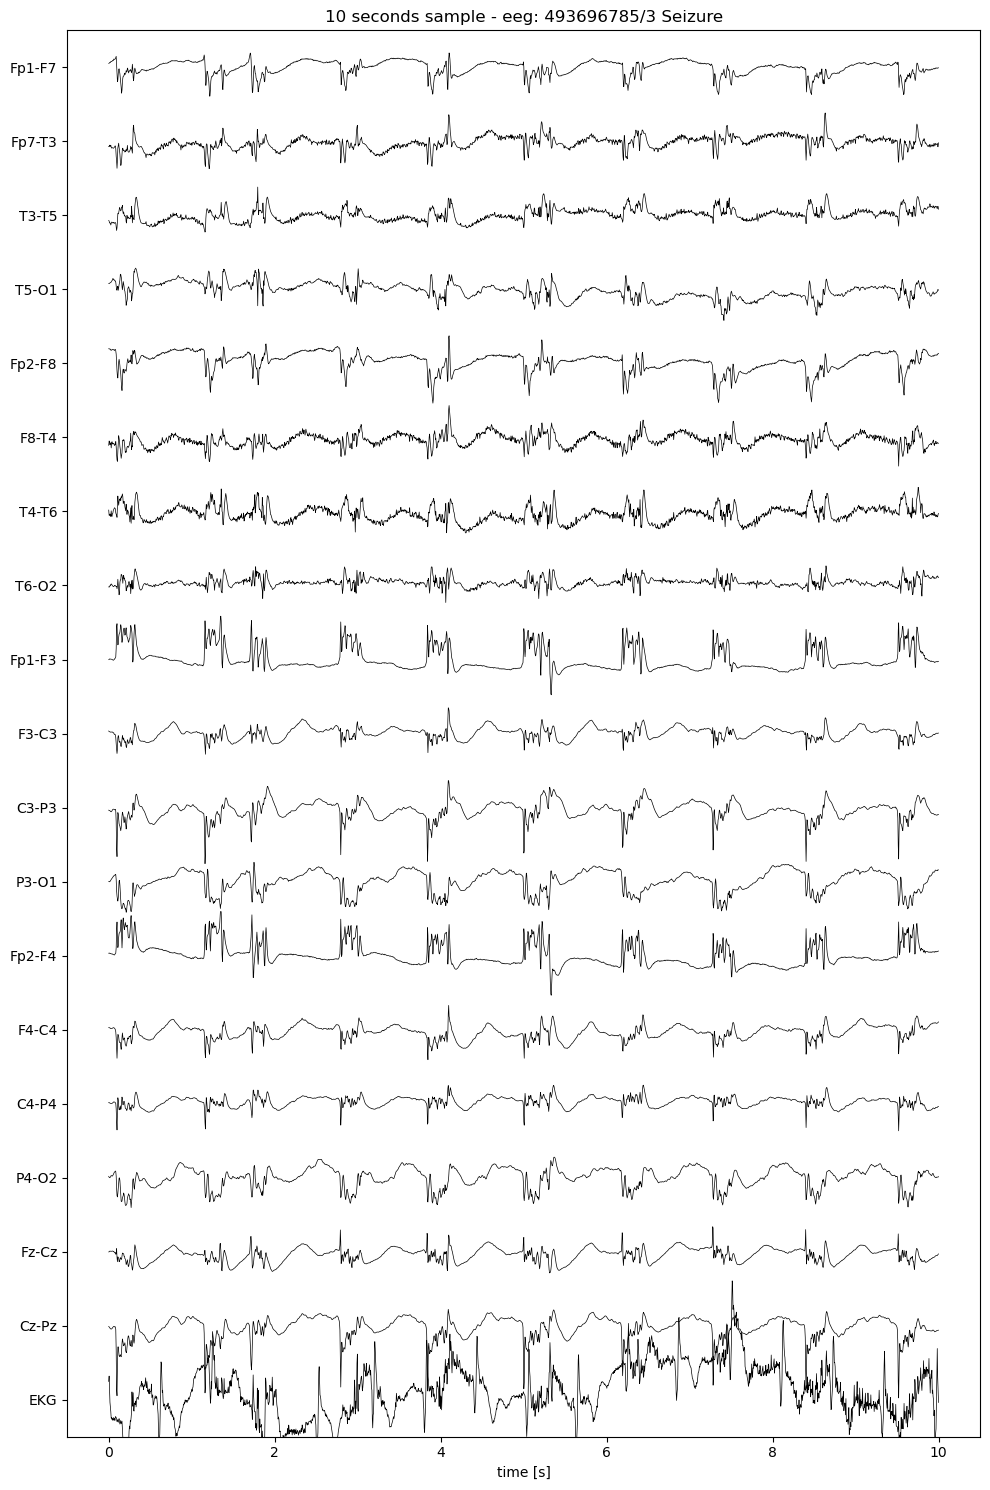

In [16]:
# 50 second and center 10 second eeg sub samples 
offset = int(item.eeg_label_offset_seconds)
start = offset * fs
end = (offset + 50) * fs
eeg_sub_50 = eeg[start:end]
start = (offset + 20) * fs
end = (offset + 30) * fs
eeg_sub_10 = eeg[start:end]

fig, ax = plt.subplots(1, 1, figsize=(10, 15))

plot_eeg(ax, eeg_sub_10, title='10 seconds sample - eeg: ' + str(item.eeg_id)
          + '/' + str(item.eeg_sub_id) + ' ' + item.expert_consensus, sep = 500)

plt.tight_layout()
plt.show()

Idea: define zones qhere maximum is observed (phase flip): localized, along a line, on both sides (horizontal), etc

## <a id='toc4_'></a>[How many different combinations of votes?](#toc0_)

These could lead to possible classes, with a mixture of votes.

In [7]:
# Only eegs with 5 or less NaN rows.
idxs_wo_nan = np.load("../data/02_eegs_idxs_up_to_5_nan.npy")
df = df_traincsv.iloc[idxs_wo_nan]
print("Number of observations with 5 or less NaN rows:",len(df))


Number of observations with 5 or less NaN rows: 106358


In [13]:
df.sample(10)

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
52324,2139276190,12,28.0,1033541380,12,28.0,3302386793,31321,LRDA,0,0,0,2,0,1
39854,401608387,3,10.0,764146759,950,16404.0,3337580221,30631,LPD,0,3,0,0,0,0
19181,1358432892,0,0.0,372801019,8,744.0,3098465677,26177,Seizure,3,0,0,0,0,0
24415,793260552,6,28.0,481081757,13,808.0,3727125744,45528,Other,0,2,0,0,0,3
59556,464391702,8,40.0,1194252646,8,40.0,1767774974,33392,Other,3,2,0,5,0,7
12134,4135680824,0,0.0,234780724,0,0.0,878247535,58098,Other,0,0,0,0,0,2
33441,1639717868,23,78.0,655087439,26,134.0,783004181,30631,LRDA,0,5,0,6,0,0
53429,2326778787,1,2.0,1058916721,1,2.0,3128615526,41897,LRDA,0,0,0,3,0,0
2878,1303727381,3,12.0,41460432,3,12.0,3765531970,37624,Seizure,3,0,0,0,0,2
34647,653687449,70,242.0,683350709,70,242.0,3827082139,45536,GPD,5,0,7,0,0,2


For each observation, calculate the percentage of each vote:

['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']  
[3,0,0,0,0,0] = [1,0,0,0,0,0]  
[0,0,2,0,1]  =  [0,0,0.667,0,0.333]  


In [16]:
df['sum_votes'] = df.seizure_vote + df.lpd_vote + df.gpd_vote	+ df.lrda_vote + df.grda_vote + df.other_vote
df['seizure_vote'] = df.seizure_vote/df.sum_votes
df['lpd_vote'] = df.lpd_vote/df.sum_votes
df['gpd_vote'] = df.gpd_vote/df.sum_votes
df['lrda_vote'] = df.lrda_vote/df.sum_votes
df['grda_vote'] = df.grda_vote/df.sum_votes
df['other_vote'] = df.other_vote/df.sum_votes


/tmp/ipykernel_34251/1606762932.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sum_votes'] = df.seizure_vote + df.lpd_vote + df.gpd_vote	+ df.lrda_vote + df.grda_vote + df.other_vote
/tmp/ipykernel_34251/1606762932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seizure_vote'] = df.seizure_vote/df.sum_votes
/tmp/ipykernel_34251/1606762932.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [24]:
df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].drop_duplicates()


,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.454545,0.000000,0.090909,0.454545
11,0.000000,0.062500,0.000000,0.875000,0.000000,0.062500
22,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
30,0.230769,0.000000,0.769231,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
106623,0.200000,0.000000,0.000000,0.800000,0.000000,0.000000
106683,0.000000,0.071429,0.000000,0.357143,0.000000,0.571429
106713,0.000000,0.636364,0.090909,0.000000,0.000000,0.272727
106731,0.000000,0.066667,0.000000,0.666667,0.000000,0.266667


<div class="alert alert-block alert-info">&rdsh; 3128 different combinations of votes.</div>

Find the similarity between these combinations.

In [13]:
estimator = KMeans(n_clusters=20)
X = df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
estimator.fit(X)

/home/edg/miniconda3/envs/gsdc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=20)

In [14]:
estimator.cluster_centers_

array([[4.45267959e-01, 5.33865450e+00, 5.19954390e-01, 1.05416192e+00,
        4.25883694e-01, 6.03135690e+00],
       [1.59732541e-01, 2.75780089e-01, 2.39806835e+00, 3.07578009e-02,
        1.09658247e-01, 3.11738484e-01],
       [2.06868357e-01, 4.70427910e-01, 2.04415372e-01, 6.84464432e+00,
        1.08748978e+00, 4.63668575e+00],
       [1.16266945e-01, 2.53388947e-01, 1.53284672e-01, 2.37226277e-01,
        1.80396246e-01, 1.80912409e+01],
       [1.52617841e-01, 2.67695378e+00, 6.38722555e-02, 1.23138339e-01,
        2.36450177e-02, 2.18179027e-01],
       [3.45103932e-01, 6.04057100e-01, 1.24815928e+01, 5.50964187e-02,
        2.00350614e-01, 7.85624843e-01],
       [5.50588235e-02, 1.03529412e-01, 2.94588235e-01, 1.72235294e-01,
        1.16512941e+01, 2.07388235e+00],
       [3.15371571e+00, 4.12468828e-02, 2.97755611e-02, 2.97256858e-02,
        1.29177057e-02, 8.68827930e-02],
       [1.18045113e-02, 1.69924812e-02, 1.77443609e-02, 8.03759398e-02,
        2.84263158e+00, 